# Mini Challenge : TLC Taxi Type Analysis (Jan 2024)
**Using DuckDB for High-Performance Data Processing**

**Student:** Akawat Moradsatian 6609681231  
**RAM Requirement:** 16GB  
**Technology Stack:** DuckDB, Python, Pandas, Matplotlib

**Web Version:** [ipynb](http://petchsko123.trueddns.com:56260/statichtml/CS341Lab01/)

## 1. Ingest Stage (Data Pipeline)
**Pipeline Stage: Data Ingestion**

เป็นจุดแรกที่นำข้อมูลเข้าข้อมูลเพื่อทำการจัดการข้อมูล โดยเก็บเข้าสู่ Storage แบบ Non Persistant (ดึงเข้าข้อมูลแล้วใช้เลย)

### Dataset Variable URL
Link to Acquire Dataset : TLC Trip Record Data (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [ ]:
# import necessary libraries
import os
import requests
import json
import pandas as pd
import duckdb
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import matplotlib.pyplot as plt

# Initialize DuckDB connection
conn = duckdb.connect()

# Stored Folder
folder = "tlctrip_data"
cleaned_folder = "cleaned_data"
merged_folder = "merged_data"

In [ ]:
# Yellow Taxi Dataset URL
yellow = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"

# Green Taxi Dataset URL
green = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet"

# Full-Hire Vehicle Dataset URL
fhv = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2024-01.parquet"

# High Volume Full-Hire Vehicle Dataset URL
fhv_hv = "https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-01.parquet"

### Download Data to Storage

In [ ]:
# Create Folder
os.makedirs(folder, exist_ok=True)

# Download Yellow Taxi Dataset to Storage
!curl -o {folder}/yellow_tripdata_2024-01.parquet {yellow}

# Download Green Taxi Dataset tp Storage
!curl -o {folder}/green_tripdata_2024-01.parquet {green}

# Download Full-Hire Vehicle Dataset to Storage
!curl -o {folder}/fhv_tripdata_2024-01.parquet {fhv}

# Download High Volume Full-Hire Vehicle Dataset to Storage
!curl -o {folder}/fhvhv_tripdata_2024-01.parquet {fhv_hv}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 47.6M    0  372k    0     0   240k      0  0:03:23  0:00:01  0:03:22  240k
 29 47.6M   29 13.9M    0     0  5599k      0  0:00:08  0:00:02  0:00:06 5602k
 79 47.6M   79 37.7M    0     0  10.6M      0  0:00:04  0:00:03  0:00:01 10.6M
100 47.6M  100 47.6M    0     0  12.0M      0  0:00:03  0:00:03 --:--:-- 12.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 1330k    1 16384    0     0  30758      0  0:00:44 --:--:--  0:00:44 30854
100 1330k  100 1330k    0     0   955k      0  0:0

### Display all the dataframe

#### Yellow Taxi Data

In [ ]:
# Load Dataset
yellowdf = pd.read_parquet(f"{folder}/yellow_tripdata_2024-01.parquet")

print("-- Data --")
display(yellowdf)

print("-- describe --")
pd.set_option('display.float_format', '{:.2f}'.format)
display(yellowdf.describe())

print("-- Data Type --")
display(yellowdf.info())

# Unload to save ram
del yellowdf

-- Data --


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.00,1.72,1.00,N,186,79,2,17.70,1.00,0.50,0.00,0.00,1.00,22.70,2.50,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.00,1.80,1.00,N,140,236,1,10.00,3.50,0.50,3.75,0.00,1.00,18.75,2.50,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.00,4.70,1.00,N,236,79,1,23.30,3.50,0.50,3.00,0.00,1.00,31.30,2.50,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.00,1.40,1.00,N,79,211,1,10.00,3.50,0.50,2.00,0.00,1.00,17.00,2.50,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.00,0.80,1.00,N,211,148,1,7.90,3.50,0.50,3.20,0.00,1.00,16.10,2.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.50,2.00,0.00,1.00,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.50,2.34,0.00,1.00,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.50,0.00,0.00,1.00,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.50,5.58,0.00,1.00,33.46,NaN,NaN


-- describe --


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2964624.00,2964624,2964624,2824462.00,2964624.00,2824462.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2964624.00,2824462.00,2824462.00
mean,1.75,2024-01-17 00:46:36.431092,2024-01-17 01:02:13.208130,1.34,3.65,2.07,166.02,165.12,1.16,18.18,1.45,0.48,3.34,0.53,0.98,26.80,2.26,0.14
min,1.00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.00,0.00,1.00,1.00,1.00,0.00,-899.00,-7.50,-0.50,-80.00,-80.00,-1.00,-900.00,-2.50,-1.75
25%,2.00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.00,1.00,1.00,132.00,114.00,1.00,8.60,0.00,0.50,1.00,0.00,1.00,15.38,2.50,0.00
50%,2.00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.00,1.68,1.00,162.00,162.00,1.00,12.80,1.00,0.50,2.70,0.00,1.00,20.10,2.50,0.00
75%,2.00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.00,3.11,1.00,234.00,234.00,1.00,20.50,2.50,0.50,4.12,0.00,1.00,28.56,2.50,0.00
max,6.00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.00,312722.30,99.00,265.00,265.00,4.00,5000.00,14.25,4.00,428.00,115.92,1.00,5000.00,2.50,1.75
std,0.43,NaN,NaN,0.85,225.46,9.82,63.62,69.32,0.58,18.95,1.80,0.12,3.90,2.13,0.22,23.39,0.82,0.49


-- Data Type --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airpor

None

#### Green Taxi Dataset

In [ ]:
# Load Dataset
greendf = pd.read_parquet(f"{folder}/green_tripdata_2024-01.parquet")

print("-- Data --")
display(greendf)

print("-- describe --")
pd.set_option('display.float_format', '{:.2f}'.format)
display(greendf.describe())

print("-- Data Type --")
display(greendf.info())

# Unload to save ram
del greendf

-- Data --


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.00,236,239,1.00,1.98,12.80,1.00,0.50,3.61,0.00,NaN,1.00,21.66,1.00,1.00,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.00,65,170,5.00,6.54,30.30,1.00,0.50,7.11,0.00,NaN,1.00,42.66,1.00,1.00,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.00,74,262,1.00,3.08,19.80,1.00,0.50,3.00,0.00,NaN,1.00,28.05,1.00,1.00,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.00,74,116,1.00,2.40,14.20,1.00,1.50,0.00,0.00,NaN,1.00,16.70,2.00,1.00,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.00,74,243,1.00,5.14,22.60,1.00,0.50,6.28,0.00,NaN,1.00,31.38,1.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,0.00,0.00,3.14,0.00,NaN,1.00,15.72,NaN,NaN,NaN
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,0.00,0.00,0.00,0.00,NaN,1.00,12.58,NaN,NaN,NaN
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,0.00,0.00,2.52,0.00,NaN,1.00,15.10,NaN,NaN,NaN
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,0.00,0.00,0.00,0.00,NaN,1.00,15.22,NaN,NaN,NaN


-- describe --


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,56551.00,56551,56551,53136.00,56551.00,56551.00,53136.00,56551.00,56551.00,56551.00,56551.00,56551.00,56551.00,0.00,56551.00,56551.00,53136.00,53133.00,53136.00
mean,1.87,2024-01-16 21:13:00.132941,2024-01-16 21:31:10.415660,1.15,96.08,140.50,1.31,31.49,16.93,0.90,0.58,2.26,0.19,NaN,0.98,22.40,1.32,1.03,0.78
min,1.00,2023-12-31 14:38:47,2023-12-31 14:46:45,1.00,1.00,1.00,0.00,0.00,-70.00,-5.00,-0.50,-1.66,0.00,NaN,-1.00,-76.50,1.00,1.00,-2.75
25%,2.00,2024-01-09 10:57:45,2024-01-09 11:20:21,1.00,74.00,74.00,1.00,1.10,9.30,0.00,0.50,0.00,0.00,NaN,1.00,13.44,1.00,1.00,0.00
50%,2.00,2024-01-17 07:20:09,2024-01-17 07:34:18,1.00,75.00,140.00,1.00,1.79,13.50,0.00,0.50,2.00,0.00,NaN,1.00,18.42,1.00,1.00,0.00
75%,2.00,2024-01-24 15:28:22,2024-01-24 15:40:44,1.00,112.00,225.00,1.00,3.08,19.80,2.50,0.50,3.50,0.00,NaN,1.00,26.60,2.00,1.00,2.75
max,2.00,2024-01-31 23:57:29,2024-02-01 19:17:30,99.00,265.00,265.00,9.00,201421.68,1422.60,10.25,4.25,110.00,24.05,NaN,1.00,1424.10,5.00,2.00,2.75
std,0.34,NaN,NaN,1.05,57.86,76.56,0.98,1417.46,15.36,1.34,0.38,2.85,1.19,NaN,0.14,16.96,0.50,0.18,1.24


-- Data Type --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56551 entries, 0 to 56550
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56551 non-null  int32         
 1   lpep_pickup_datetime   56551 non-null  datetime64[us]
 2   lpep_dropoff_datetime  56551 non-null  datetime64[us]
 3   store_and_fwd_flag     53136 non-null  object        
 4   RatecodeID             53136 non-null  float64       
 5   PULocationID           56551 non-null  int32         
 6   DOLocationID           56551 non-null  int32         
 7   passenger_count        53136 non-null  float64       
 8   trip_distance          56551 non-null  float64       
 9   fare_amount            56551 non-null  float64       
 10  extra                  56551 non-null  float64       
 11  mta_tax                56551 non-null  float64       
 12  tip_amount             56551 non-null  float

None

#### Full Hire Vehicle

In [ ]:
# Load Dataset
fhvdf = pd.read_parquet(f"{folder}/fhv_tripdata_2024-01.parquet")

print("-- Data --")
display(fhvdf)

print("-- describe --")
pd.set_option('display.float_format', '{:.2f}'.format)
display(fhvdf.describe())

print("-- Data Type --")
display(fhvdf.info())

# Unload to save ram
del fhvdf

-- Data --


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00053,2024-01-01 00:15:00,2024-01-01 02:13:00,NaN,NaN,NaN,B00014
1,B00111,2024-01-01 00:30:00,2024-01-01 02:37:00,NaN,NaN,NaN,B00111
2,B00112,2024-01-01 00:27:24,2024-01-01 01:12:05,NaN,14.00,NaN,B00112
3,B00112,2024-01-01 00:10:09,2024-01-01 00:25:39,NaN,133.00,NaN,B00112
4,B00112,2024-01-01 00:57:07,2024-01-01 01:05:04,NaN,14.00,NaN,B00112
...,...,...,...,...,...,...,...
1290111,B03492,2024-01-31 23:51:21,2024-01-31 23:57:09,NaN,14.00,NaN,B03492
1290112,B03492,2024-01-31 23:05:06,2024-01-31 23:20:13,NaN,21.00,NaN,B03492
1290113,B03492,2024-01-31 23:49:07,2024-02-01 00:16:25,NaN,14.00,NaN,B03492
1290114,B03505,2024-01-31 23:04:46,2024-01-31 23:18:22,NaN,76.00,NaN,B03505


-- describe --


,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag
count,1290116,1290116,274816.00,1107055.00,0.00
mean,2024-01-16 22:59:15.936936,2024-01-16 23:33:26.867784,134.29,135.18,NaN
min,2024-01-01 00:00:01,2024-01-01 00:03:56,1.00,1.00,NaN
25%,2024-01-09 12:45:24.750000,2024-01-09 13:11:52.750000,72.00,69.00,NaN
50%,2024-01-17 09:11:49,2024-01-17 09:39:28,133.00,132.00,NaN
75%,2024-01-24 13:07:29.500000,2024-01-24 13:41:00,206.00,212.00,NaN
max,2024-01-31 23:59:59,2025-01-25 06:35:00,265.00,265.00,NaN
std,NaN,NaN,74.42,78.89,NaN


-- Data Type --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290116 entries, 0 to 1290115
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1290116 non-null  object        
 1   pickup_datetime         1290116 non-null  datetime64[us]
 2   dropOff_datetime        1290116 non-null  datetime64[us]
 3   PUlocationID            274816 non-null   float64       
 4   DOlocationID            1107055 non-null  float64       
 5   SR_Flag                 0 non-null        float64       
 6   Affiliated_base_number  1290116 non-null  object        
dtypes: datetime64[us](2), float64(3), object(2)
memory usage: 68.9+ MB


None

#### High Volume Full-Hire Vehicle

In [ ]:
# Load Dataset
fhvhvdf = pd.read_parquet(f"{folder}/fhvhv_tripdata_2024-01.parquet")

print("-- Data --")
display(fhvhvdf.head())

print("-- describe --")
pd.set_option('display.float_format', '{:.2f}'.format)
display(fhvhvdf.describe())

print("-- Data Type --")
display(fhvhvdf.info())

# Unload to save ram
del fhvhvdf

-- Data --


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-01-01 00:21:47,2024-01-01 00:25:06,2024-01-01 00:28:08,2024-01-01 01:05:39,161,158,2.83,...,4.05,2.75,0.00,0.00,40.18,N,N,N,N,N
1,HV0003,B03404,B03404,2024-01-01 00:10:56,2024-01-01 00:11:08,2024-01-01 00:12:53,2024-01-01 00:20:05,137,79,1.57,...,0.89,2.75,0.00,0.00,6.12,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-01 00:20:04,2024-01-01 00:21:51,2024-01-01 00:23:05,2024-01-01 00:35:16,79,186,1.98,...,1.60,2.75,0.00,0.00,9.47,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-01 00:35:46,2024-01-01 00:39:59,2024-01-01 00:41:04,2024-01-01 00:56:34,234,148,1.99,...,1.52,2.75,0.00,0.00,11.35,N,N,N,N,N
4,HV0003,B03404,B03404,2024-01-01 00:48:19,2024-01-01 00:56:23,2024-01-01 00:57:21,2024-01-01 01:10:02,148,97,2.65,...,3.43,2.75,0.00,0.00,28.63,N,N,N,N,N


-- describe --


,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay
count,19663930,14445193,19663930,19663930,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00,19663930.00
mean,2024-01-16 22:16:37.965603,2024-01-17 02:22:41.626253,2024-01-16 22:20:45.530691,2024-01-16 22:39:15.999917,139.14,142.42,4.84,1110.47,23.96,1.06,0.69,2.03,1.08,0.19,1.06,18.27
min,2023-12-31 23:01:55,2023-12-31 22:55:22,2024-01-01 00:00:00,2024-01-01 00:02:35,1.00,1.00,0.00,0.00,-43.09,0.00,0.00,0.00,0.00,0.00,0.00,-67.76
25%,2024-01-09 14:57:44,2024-01-09 18:12:25,2024-01-09 15:01:51,2024-01-09 15:22:16,75.00,76.00,1.49,571.00,11.63,0.00,0.32,0.98,0.00,0.00,0.00,8.21
50%,2024-01-17 08:05:05.500000,2024-01-17 13:01:53,2024-01-17 08:11:56,2024-01-17 08:31:05,140.00,142.00,2.83,912.00,18.00,0.00,0.50,1.53,0.00,0.00,0.00,13.57
75%,2024-01-24 13:28:24.750000,2024-01-24 16:23:39,2024-01-24 13:31:43.750000,2024-01-24 13:52:05.750000,211.00,217.00,5.99,1430.00,28.80,0.00,0.81,2.48,2.75,0.00,0.00,22.83
max,2024-02-01 00:07:07,2024-01-31 23:59:58,2024-01-31 23:59:59,2024-02-01 02:10:41,265.00,265.00,417.62,52060.00,1911.16,141.02,53.94,152.69,8.25,6.90,196.80,1218.17
std,NaN,NaN,NaN,NaN,74.90,77.78,5.70,772.22,20.54,3.80,0.63,1.68,1.34,0.67,3.13,15.46


-- Data Type --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19663930 entries, 0 to 19663929
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int32         
 8   DOLocationID          int32         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            fl

None

## 2. Clean Stage (Data Pipeline)

ทำความสะอาดข้อมูล เนื่องจากข้อมูลจากไฟล์ข้อมูลอาจมีข้อมูลที่ไม่สมประกอบ (Inconsistency) เช่น ข้อมูลติด Null ติดลบ, มีค่ามากกว่าความเป็นจริง (Outliner) หรือข้อมูลที่ไม่ตรงกับชนิดข้อมูลนั้น ๆ

### Data Cleaning Flow using DuckDB

1. Load Dataset using DuckDB
2. Check For Duplicates using SQL queries
3. Remove Duplicates
4. Check Inconsistency like negative passenger count, negative trip distance, pickup datetime after dropoff datetime, pickup and dropoff datetime must in the 2024-01, negative fare amount, and negative tip amount
5. Remove Inconsistency
6. Check Null that is not allowed (Like datetime, passenger count, trip distance)
7. Remove Null records
8. Remove Outliers (too much fare amount, too much trip distance)
9. Save to Storage for Next Step in parquet format (lower memory usage)

### Make Folder for Cleaned Data


In [ ]:
os.makedirs(cleaned_folder, exist_ok=True)

### 1. Yellow Taxi Data Cleaning

In [ ]:
# Yellow Taxi Data Cleaning using DuckDB
print("=== Cleaning Yellow Taxi Data using DuckDB ===")

# Load and analyze Yellow Taxi Data
yellow_file = f"{folder}/yellow_tripdata_2024-01.parquet"

# First, get the original count
original_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{yellow_file}')").fetchone()[0]
print(f"Original Yellow Taxi records: {original_count:,}")

# 1. Check Duplicates using a simpler approach
duplicate_count = conn.execute(f"""
    SELECT COUNT(*) - COUNT(DISTINCT(VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, PULocationID, DOLocationID)) as duplicates
    FROM read_parquet('{yellow_file}')
""").fetchone()[0]
print(f"Yellow Taxi Duplicates: {duplicate_count}")

# 2. Check Basic Inconsistencies
basic_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{yellow_file}')
    WHERE passenger_count < 0 OR trip_distance < 0
""").fetchone()[0]
print(f"Yellow Taxi Basic Inconsistencies (negative values): {basic_inconsistent}")

# 4. Check Date Range and Fare Inconsistencies
date_fare_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{yellow_file}')
    WHERE tpep_pickup_datetime < '2024-01-01' OR tpep_pickup_datetime >= '2024-02-01'
    OR tpep_dropoff_datetime < '2024-01-01' OR tpep_dropoff_datetime >= '2024-02-01'
    OR fare_amount < 0 OR tip_amount < 0
""").fetchone()[0]
print(f"Yellow Taxi Date/Fare Inconsistencies: {date_fare_inconsistent}")

# 6. Check Nulls in critical columns
null_stats = conn.execute(f"""
    SELECT
        SUM(CASE WHEN tpep_pickup_datetime IS NULL THEN 1 ELSE 0 END) as pickup_nulls,
        SUM(CASE WHEN tpep_dropoff_datetime IS NULL THEN 1 ELSE 0 END) as dropoff_nulls,
        SUM(CASE WHEN PULocationID IS NULL THEN 1 ELSE 0 END) as pu_nulls,
        SUM(CASE WHEN DOLocationID IS NULL THEN 1 ELSE 0 END) as do_nulls,
        SUM(CASE WHEN passenger_count IS NULL THEN 1 ELSE 0 END) as passenger_nulls,
        SUM(CASE WHEN trip_distance IS NULL THEN 1 ELSE 0 END) as distance_nulls
    FROM read_parquet('{yellow_file}')
""").fetchone()
print(f"Yellow Taxi Nulls - Pickup: {null_stats[0]}, Dropoff: {null_stats[1]}, PU Location: {null_stats[2]}, DO Location: {null_stats[3]}, Passengers: {null_stats[4]}, Distance: {null_stats[5]}")

# 8. Check Outliers
outlier_stats = conn.execute(f"""
    SELECT
        COUNT(*) as extreme_fare,
        (SELECT COUNT(*) FROM read_parquet('{yellow_file}') WHERE trip_distance > 1000) as extreme_distance
    FROM read_parquet('{yellow_file}')
    WHERE fare_amount > 10000
""").fetchone()
print(f"Yellow Taxi Outliers - Extreme Fare (>$10k): {outlier_stats[0]}, Extreme Distance (>1000mi): {outlier_stats[1]}")

# Clean and save Yellow Taxi data with comprehensive filtering
cleaned_yellow = f"{cleaned_folder}/yellow_tripdata_2024-01_cleaned.parquet"
conn.execute(f"""
    COPY (
        SELECT DISTINCT *
        FROM read_parquet('{yellow_file}')
        WHERE passenger_count >= 0
        AND trip_distance >= 0
        AND tpep_pickup_datetime IS NOT NULL
        AND tpep_dropoff_datetime IS NOT NULL
        AND PULocationID IS NOT NULL
        AND DOLocationID IS NOT NULL
        AND passenger_count IS NOT NULL
        AND trip_distance IS NOT NULL
        AND tpep_dropoff_datetime > tpep_pickup_datetime
        AND tpep_pickup_datetime >= '2024-01-01' AND tpep_pickup_datetime < '2024-02-01'
        AND tpep_dropoff_datetime >= '2024-01-01' AND tpep_dropoff_datetime < '2024-02-01'
        AND fare_amount >= 0 AND tip_amount >= 0
        AND fare_amount <= 10000 AND trip_distance <= 1000
    ) TO '{cleaned_yellow}' (FORMAT PARQUET)
""")

# Get final count
final_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{cleaned_yellow}')").fetchone()[0]
records_removed = original_count - final_count
print(f"Yellow Taxi - Final cleaned records: {final_count:,} (removed {records_removed:,})")
print("✓ Yellow Taxi cleaning completed\n")

=== Cleaning Yellow Taxi Data using DuckDB ===
Original Yellow Taxi records: 2,964,624
Yellow Taxi Duplicates: 31101
Yellow Taxi Basic Inconsistencies (negative values): 0
Yellow Taxi Date/Fare Inconsistencies: 38062
Yellow Taxi Nulls - Pickup: 0, Dropoff: 0, PU Location: 0, DO Location: 0, Passengers: 140162, Distance: 0
Yellow Taxi Outliers - Extreme Fare (>$10k): 0, Extreme Distance (>1000mi): 23


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Yellow Taxi - Final cleaned records: 2,787,716 (removed 176,908)
✓ Yellow Taxi cleaning completed



#### 2. Green Taxi Data Cleaning

In [ ]:
# Green Taxi Data Cleaning using DuckDB
print("=== Cleaning Green Taxi Data using DuckDB ===")

# Load and analyze Green Taxi Data
green_file = f"{folder}/green_tripdata_2024-01.parquet"

# First, get the original count
original_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{green_file}')").fetchone()[0]
print(f"Original Green Taxi records: {original_count:,}")

# 1. Check Duplicates using a simpler approach
duplicate_count = conn.execute(f"""
    SELECT COUNT(*) - COUNT(DISTINCT(VendorID, lpep_pickup_datetime, lpep_dropoff_datetime, passenger_count, trip_distance, PULocationID, DOLocationID)) as duplicates
    FROM read_parquet('{green_file}')
""").fetchone()[0]
print(f"Green Taxi Duplicates: {duplicate_count}")

# 2. Check Basic Inconsistencies
basic_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{green_file}')
    WHERE passenger_count < 0 OR trip_distance < 0
""").fetchone()[0]
print(f"Green Taxi Basic Inconsistencies (negative values): {basic_inconsistent}")

# 4. Check Date Range and Fare Inconsistencies
date_fare_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{green_file}')
    WHERE lpep_pickup_datetime < '2024-01-01' OR lpep_pickup_datetime >= '2024-02-01'
    OR lpep_dropoff_datetime < '2024-01-01' OR lpep_dropoff_datetime >= '2024-02-01'
    OR fare_amount < 0 OR tip_amount < 0
""").fetchone()[0]
print(f"Green Taxi Date/Fare Inconsistencies: {date_fare_inconsistent}")

# 6. Check Nulls in critical columns
null_stats = conn.execute(f"""
    SELECT
        SUM(CASE WHEN lpep_pickup_datetime IS NULL THEN 1 ELSE 0 END) as pickup_nulls,
        SUM(CASE WHEN lpep_dropoff_datetime IS NULL THEN 1 ELSE 0 END) as dropoff_nulls,
        SUM(CASE WHEN PULocationID IS NULL THEN 1 ELSE 0 END) as pu_nulls,
        SUM(CASE WHEN DOLocationID IS NULL THEN 1 ELSE 0 END) as do_nulls,
        SUM(CASE WHEN passenger_count IS NULL THEN 1 ELSE 0 END) as passenger_nulls,
        SUM(CASE WHEN trip_distance IS NULL THEN 1 ELSE 0 END) as distance_nulls
    FROM read_parquet('{green_file}')
""").fetchone()
print(f"Green Taxi Nulls - Pickup: {null_stats[0]}, Dropoff: {null_stats[1]}, PU Location: {null_stats[2]}, DO Location: {null_stats[3]}, Passengers: {null_stats[4]}, Distance: {null_stats[5]}")

# 8. Check Outliers
outlier_stats = conn.execute(f"""
    SELECT
        COUNT(*) as extreme_fare,
        (SELECT COUNT(*) FROM read_parquet('{green_file}') WHERE trip_distance > 1000) as extreme_distance
    FROM read_parquet('{green_file}')
    WHERE fare_amount > 10000
""").fetchone()
print(f"Green Taxi Outliers - Extreme Fare (>$10k): {outlier_stats[0]}, Extreme Distance (>1000mi): {outlier_stats[1]}")

# Clean and save Green Taxi data with comprehensive filtering
cleaned_green = f"{cleaned_folder}/green_tripdata_2024-01_cleaned.parquet"
conn.execute(f"""
    COPY (
        SELECT DISTINCT *
        FROM read_parquet('{green_file}')
        WHERE passenger_count >= 0
        AND trip_distance >= 0
        AND lpep_pickup_datetime IS NOT NULL
        AND lpep_dropoff_datetime IS NOT NULL
        AND PULocationID IS NOT NULL
        AND DOLocationID IS NOT NULL
        AND passenger_count IS NOT NULL
        AND trip_distance IS NOT NULL
        AND lpep_dropoff_datetime > lpep_pickup_datetime
        AND lpep_pickup_datetime >= '2024-01-01' AND lpep_pickup_datetime < '2024-02-01'
        AND lpep_dropoff_datetime >= '2024-01-01' AND lpep_dropoff_datetime < '2024-02-01'
        AND fare_amount >= 0 AND tip_amount >= 0
        AND fare_amount <= 10000 AND trip_distance <= 1000
    ) TO '{cleaned_green}' (FORMAT PARQUET)
""")

# Get final count
final_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{cleaned_green}')").fetchone()[0]
records_removed = original_count - final_count
print(f"Green Taxi - Final cleaned records: {final_count:,} (removed {records_removed:,})")
print("✓ Green Taxi cleaning completed\n")

=== Cleaning Green Taxi Data using DuckDB ===
Original Green Taxi records: 56,551
Green Taxi Duplicates: 181
Green Taxi Basic Inconsistencies (negative values): 0
Green Taxi Date/Fare Inconsistencies: 199
Green Taxi Nulls - Pickup: 0, Dropoff: 0, PU Location: 0, DO Location: 0, Passengers: 3415, Distance: 0
Green Taxi Outliers - Extreme Fare (>$10k): 0, Extreme Distance (>1000mi): 46
Green Taxi - Final cleaned records: 52,888 (removed 3,663)
✓ Green Taxi cleaning completed



#### 3. Full Hire Vehicle Data Cleaning

In [ ]:
# FHV Data Cleaning using DuckDB
print("=== Cleaning FHV Data using DuckDB ===")

# Load and analyze FHV Data
fhv_file = f"{folder}/fhv_tripdata_2024-01.parquet"

# First, get the original count
original_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{fhv_file}')").fetchone()[0]
print(f"Original FHV records: {original_count:,}")

# 1. Check Duplicates using a simpler approach
duplicate_count = conn.execute(f"""
    SELECT COUNT(*) - COUNT(DISTINCT(dispatching_base_num, pickup_datetime, dropOff_datetime, PUlocationID, DOlocationID)) as duplicates
    FROM read_parquet('{fhv_file}')
""").fetchone()[0]
print(f"FHV Duplicates: {duplicate_count}")

# 2. Check Basic Inconsistencies (pickup/dropoff datetime order)
basic_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{fhv_file}')
    WHERE dropOff_datetime < pickup_datetime
""").fetchone()[0]
print(f"FHV Basic Inconsistencies (dropoff before pickup): {basic_inconsistent}")

# 4. Check Date Range Inconsistencies
date_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{fhv_file}')
    WHERE pickup_datetime < '2024-01-01' OR pickup_datetime >= '2024-02-01'
    OR dropOff_datetime < '2024-01-01' OR dropOff_datetime >= '2024-02-01'
""").fetchone()[0]
print(f"FHV Date Range Inconsistencies: {date_inconsistent}")

# 6. Check Nulls in critical columns
null_stats = conn.execute(f"""
    SELECT
        SUM(CASE WHEN pickup_datetime IS NULL THEN 1 ELSE 0 END) as pickup_nulls,
        SUM(CASE WHEN dropOff_datetime IS NULL THEN 1 ELSE 0 END) as dropoff_nulls,
        SUM(CASE WHEN PUlocationID IS NULL THEN 1 ELSE 0 END) as pu_nulls,
        SUM(CASE WHEN DOlocationID IS NULL THEN 1 ELSE 0 END) as do_nulls,
        SUM(CASE WHEN dispatching_base_num IS NULL THEN 1 ELSE 0 END) as base_nulls
    FROM read_parquet('{fhv_file}')
""").fetchone()
print(f"FHV Nulls - Pickup: {null_stats[0]}, Dropoff: {null_stats[1]}, PU Location: {null_stats[2]}, DO Location: {null_stats[3]}, Base: {null_stats[4]}")

# Clean and save FHV data with comprehensive filtering
cleaned_fhv = f"{cleaned_folder}/fhv_tripdata_2024-01_cleaned.parquet"
conn.execute(f"""
    COPY (
        SELECT DISTINCT *
        FROM read_parquet('{fhv_file}')
        WHERE pickup_datetime IS NOT NULL
        AND dropOff_datetime IS NOT NULL
        AND PUlocationID IS NOT NULL
        AND DOlocationID IS NOT NULL
        AND dispatching_base_num IS NOT NULL
        AND dropOff_datetime > pickup_datetime
        AND pickup_datetime >= '2024-01-01' AND pickup_datetime < '2024-02-01'
        AND dropOff_datetime >= '2024-01-01' AND dropOff_datetime < '2024-02-01'
    ) TO '{cleaned_fhv}' (FORMAT PARQUET)
""")

# Get final count
final_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{cleaned_fhv}')").fetchone()[0]
records_removed = original_count - final_count
print(f"FHV - Final cleaned records: {final_count:,} (removed {records_removed:,})")
print("✓ FHV cleaning completed\n")

=== Cleaning FHV Data using DuckDB ===
Original FHV records: 1,290,116
FHV Duplicates: 2639
FHV Basic Inconsistencies (dropoff before pickup): 0
FHV Date Range Inconsistencies: 594
FHV Nulls - Pickup: 0, Dropoff: 0, PU Location: 1015300, DO Location: 183061, Base: 0
FHV - Final cleaned records: 262,657 (removed 1,027,459)
✓ FHV cleaning completed



#### 4. High Volume FHV Data Cleaning

In [ ]:
# FHVHV Data Cleaning using DuckDB
print("=== Cleaning FHVHV Data using DuckDB ===")

# Load and analyze FHVHV Data
fhvhv_file = f"{folder}/fhvhv_tripdata_2024-01.parquet"

# First, get the original count
original_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{fhvhv_file}')").fetchone()[0]
print(f"Original FHVHV records: {original_count:,}")

# 1. Check Duplicates using a simpler approach
duplicate_count = conn.execute(f"""
    SELECT COUNT(*) - COUNT(DISTINCT(hvfhs_license_num, pickup_datetime, dropoff_datetime, PULocationID, DOLocationID)) as duplicates
    FROM read_parquet('{fhvhv_file}')
""").fetchone()[0]
print(f"FHVHV Duplicates: {duplicate_count}")

# 2. Check Basic Inconsistencies (pickup/dropoff datetime order)
basic_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{fhvhv_file}')
    WHERE dropoff_datetime < pickup_datetime
""").fetchone()[0]
print(f"FHVHV Basic Inconsistencies (dropoff before pickup): {basic_inconsistent}")

# 4. Check Date Range Inconsistencies
date_inconsistent = conn.execute(f"""
    SELECT COUNT(*) as inconsistent_count
    FROM read_parquet('{fhvhv_file}')
    WHERE pickup_datetime < '2024-01-01' OR pickup_datetime >= '2024-02-01'
    OR dropoff_datetime < '2024-01-01' OR dropoff_datetime >= '2024-02-01'
""").fetchone()[0]
print(f"FHVHV Date Range Inconsistencies: {date_inconsistent}")

# 6. Check Nulls in critical columns
null_stats = conn.execute(f"""
    SELECT
        SUM(CASE WHEN pickup_datetime IS NULL THEN 1 ELSE 0 END) as pickup_nulls,
        SUM(CASE WHEN dropoff_datetime IS NULL THEN 1 ELSE 0 END) as dropoff_nulls,
        SUM(CASE WHEN PULocationID IS NULL THEN 1 ELSE 0 END) as pu_nulls,
        SUM(CASE WHEN DOLocationID IS NULL THEN 1 ELSE 0 END) as do_nulls,
        SUM(CASE WHEN hvfhs_license_num IS NULL THEN 1 ELSE 0 END) as license_nulls
    FROM read_parquet('{fhvhv_file}')
""").fetchone()
print(f"FHVHV Nulls - Pickup: {null_stats[0]}, Dropoff: {null_stats[1]}, PU Location: {null_stats[2]}, DO Location: {null_stats[3]}, License: {null_stats[4]}")

# Clean and save FHVHV data with comprehensive filtering
cleaned_fhvhv = f"{cleaned_folder}/fhvhv_tripdata_2024-01_cleaned.parquet"
conn.execute(f"""
    COPY (
        SELECT DISTINCT *
        FROM read_parquet('{fhvhv_file}')
        WHERE pickup_datetime IS NOT NULL
        AND dropoff_datetime IS NOT NULL
        AND PULocationID IS NOT NULL
        AND DOLocationID IS NOT NULL
        AND hvfhs_license_num IS NOT NULL
        AND dropoff_datetime > pickup_datetime
        AND pickup_datetime >= '2024-01-01' AND pickup_datetime < '2024-02-01'
        AND dropoff_datetime >= '2024-01-01' AND dropoff_datetime < '2024-02-01'
    ) TO '{cleaned_fhvhv}' (FORMAT PARQUET)
""")

# Get final count
final_count = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{cleaned_fhvhv}')").fetchone()[0]
records_removed = original_count - final_count
print(f"FHVHV - Final cleaned records: {final_count:,} (removed {records_removed:,})")
print("✓ FHVHV cleaning completed\n")

=== Cleaning FHVHV Data using DuckDB ===
Original FHVHV records: 19,663,930


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FHVHV Duplicates: 38
FHVHV Basic Inconsistencies (dropoff before pickup): 0
FHVHV Date Range Inconsistencies: 6584
FHVHV Nulls - Pickup: 0, Dropoff: 0, PU Location: 0, DO Location: 0, License: 0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FHVHV - Final cleaned records: 19,657,344 (removed 6,586)
✓ FHVHV cleaning completed



## 3. Transform Stage (Data Pipeline)

รวมข้อมูลจากทุกประเภทรถแท็กซี่ให้เป็น Schema เดียวกัน และเตรียมข้อมูลสำหรับการวิเคราะห์

### Merge All Datasets using DuckDB
ใช้ DuckDB ในการรวมข้อมูลจากทุกประเภทรถแท็กซี่ให้มี Schema เดียวกัน และเพิ่มคอลัมน์ 'type' เพื่อแยกประเภท

In [ ]:
# Create merged folder
os.makedirs(merged_folder, exist_ok=True)

print("=== Merging All Datasets using DuckDB ===")

# Define the merged file path
merged_file = f"{merged_folder}/merged_tripdata_2024-01.parquet"

# Remove existing merged file if it exists
if os.path.exists(merged_file):
    os.remove(merged_file)

# Merge all datasets using DuckDB with standardized schema
merge_query = f"""
    COPY (
        -- Yellow Taxi data
        SELECT
            'Yellow' as type,
            tpep_pickup_datetime as pickup_datetime,
            tpep_dropoff_datetime as dropoff_datetime,
            PULocationID,
            DOLocationID
        FROM read_parquet('{cleaned_folder}/yellow_tripdata_2024-01_cleaned.parquet')

        UNION ALL

        -- Green Taxi data
        SELECT
            'Green' as type,
            lpep_pickup_datetime as pickup_datetime,
            lpep_dropoff_datetime as dropoff_datetime,
            PULocationID,
            DOLocationID
        FROM read_parquet('{cleaned_folder}/green_tripdata_2024-01_cleaned.parquet')

        UNION ALL

        -- FHV data
        SELECT
            'FHV' as type,
            pickup_datetime,
            dropOff_datetime as dropoff_datetime,
            PUlocationID as PULocationID,
            DOlocationID as DOLocationID
        FROM read_parquet('{cleaned_folder}/fhv_tripdata_2024-01_cleaned.parquet')

        UNION ALL

        -- FHVHV data
        SELECT
            'FHVHV' as type,
            pickup_datetime,
            dropoff_datetime,
            PULocationID,
            DOLocationID
        FROM read_parquet('{cleaned_folder}/fhvhv_tripdata_2024-01_cleaned.parquet')
    ) TO '{merged_file}' (FORMAT PARQUET)
"""

# Execute the merge query
conn.execute(merge_query)

# Verify the merge was successful
total_records = conn.execute(f"SELECT COUNT(*) FROM read_parquet('{merged_file}')").fetchone()[0]
print(f"✓ Successfully merged all datasets: {total_records:,} total records")

# Show records per type to verify
type_counts = conn.execute(f"""
    SELECT type, COUNT(*) as count
    FROM read_parquet('{merged_file}')
    GROUP BY type
    ORDER BY count DESC
""").fetchall()

print("\nRecords per taxi type after merging:")
for taxi_type, count in type_counts:
    print(f"  {taxi_type}: {count:,}")

print(f"\nMerged data saved to: {merged_file}")

=== Merging All Datasets using DuckDB ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Successfully merged all datasets: 22,760,605 total records

Records per taxi type after merging:
  FHVHV: 19,657,344
  Yellow: 2,787,716
  FHV: 262,657
  Green: 52,888

Merged data saved to: merged_data/merged_tripdata_2024-01.parquet


## 4. Aggregate Stage (Data Pipeline)

นับจำนวน trips ตามประเภทรถแท็กซี่แต่ละประเภท

### Aggregate Trip Counts by Taxi Type

In [ ]:
print("=== Aggregating Trip Counts using DuckDB ===")

# Define the merged file path
final_df = f"{merged_folder}/merged_tripdata_2024-01.parquet"

# Use DuckDB to count trips by type and rank them
trip_counts_query = f"""
    SELECT
        type as "Taxi Type",
        COUNT(*) as "Trip Count",
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as "Percentage",
        ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) as "Rank"
    FROM read_parquet('{final_df}')
    GROUP BY type
    ORDER BY "Trip Count" DESC
"""

# Execute query and get results
trip_counts_result = conn.execute(trip_counts_query).fetchall()

# Convert to pandas DataFrame for display
trip_counts = pd.DataFrame(trip_counts_result, columns=['Taxi Type', 'Trip Count', 'Percentage', 'Rank'])

# print("📊 TRIP COUNTS BY TAXI TYPE (January 2024)")
# print("=" * 60)
# display(trip_counts)

# Get the top taxi type for summary
top_taxi = trip_counts.iloc[0]
top_type = top_taxi['Taxi Type']
top_count = top_taxi['Trip Count']
top_percentage = top_taxi['Percentage']

# Additional statistics
total_trips = trip_counts['Trip Count'].sum()
print(f"\n ! Additional Statistics:")
print(f"   • Total trips across all types: {total_trips:,}")
print(f"   • Number of taxi types analyzed: {len(trip_counts)}")
print(f"   • Market share of top type: {top_percentage}%")

# Show ranking for all types
# print(f"\n! Complete Ranking:")
# for _, row in trip_counts.iterrows():
#     print(f"   {int(row['Rank'])}. {row['Taxi Type']}: {int(row['Trip Count']):,} rides ({row['Percentage']}%)")


=== Aggregating Trip Counts using DuckDB ===

 ! Additional Statistics:
   • Total trips across all types: 22,760,605
   • Number of taxi types analyzed: 4
   • Market share of top type: 86.37%


## 5. Report Stage (Data Pipeline)

แสดงผลการวิเคราะห์ในรูปแบบตารางและกราฟ พร้อมสรุปผลลัพธ์ที่ชัดเจน

### Visualize Trip Counts and Final Results

=== Final Visualization and Report ===


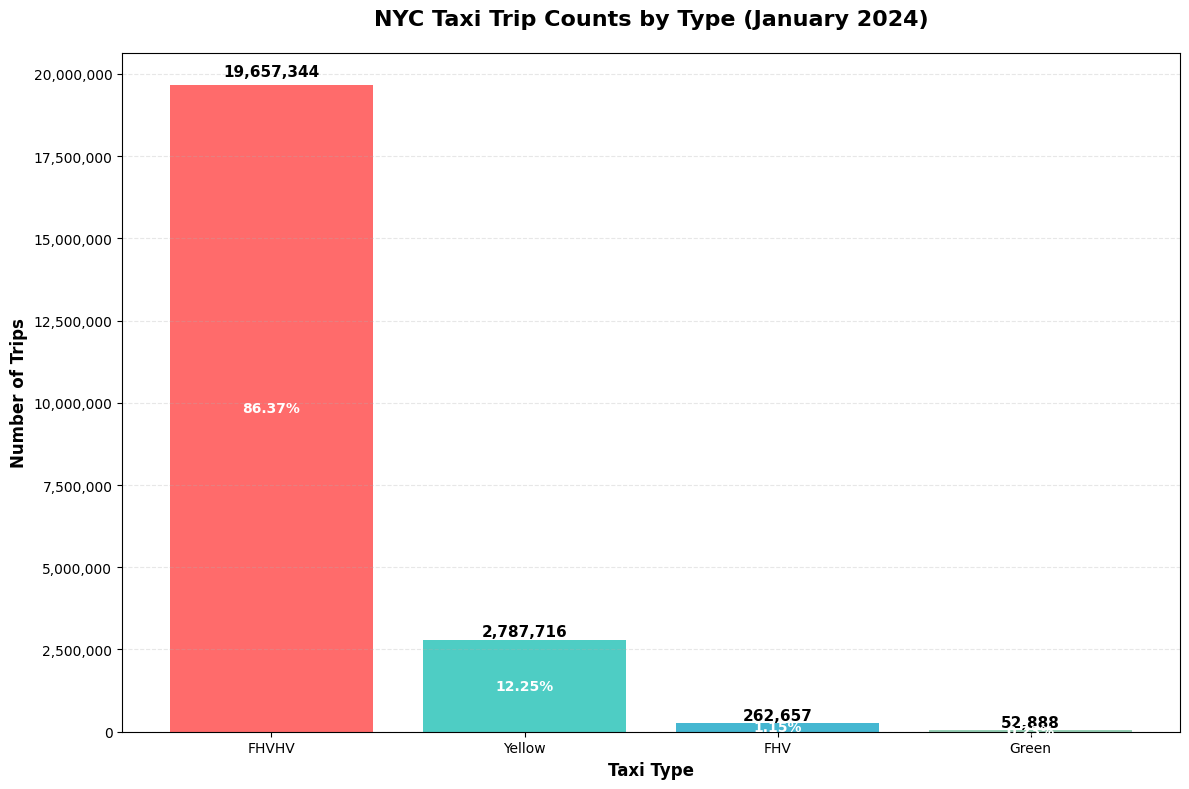


 ! FINAL ANALYSIS RESULTS
Dataset: NYC TLC Trip Record Data (January 2024)
Analysis Period: January 1-31, 2024
Total Records Processed: 22,760,605
Data Pipeline Stages: Ingest → Clean → Transform → Aggregate → Report

 ? ANSWER TO THE QUESTION:
Top taxi type (Jan 2024): FHVHV — 19,657,344 rides

 DETAILED RANKING TABLE:


,Rank,Taxi Type,Trip Count,Percentage
0,1,FHVHV,19657344,86.37
1,2,Yellow,2787716,12.25
2,3,FHV,262657,1.15
3,4,Green,52888,0.23


In [ ]:
print("=== Final Visualization and Report ===")

# Create enhanced visualization
plt.figure(figsize=(12, 8))

# Create bar chart with different colors
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(trip_counts['Taxi Type'], trip_counts['Trip Count'], color=colors)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    # Add percentage below the count
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{trip_counts.iloc[i]["Percentage"]}%', ha='center', va='center',
             color='white', fontweight='bold', fontsize=10)

plt.title('NYC Taxi Trip Counts by Type (January 2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Taxi Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Trips', fontsize=12, fontweight='bold')

# Format y-axis to show numbers with commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n" + " ! FINAL ANALYSIS RESULTS" + "\n" + "=" * 80)
print(f"Dataset: NYC TLC Trip Record Data (January 2024)")
print(f"Analysis Period: January 1-31, 2024")
print(f"Total Records Processed: {total_trips:,}")
print(f"Data Pipeline Stages: Ingest → Clean → Transform → Aggregate → Report")
print("=" * 80)

print(f"\n ? ANSWER TO THE QUESTION:")
print(f"Top taxi type (Jan 2024): {top_type} — {top_count:,} rides")
print("=" * 80)

print(f"\n DETAILED RANKING TABLE:")
display(trip_counts[['Rank', 'Taxi Type', 'Trip Count', 'Percentage']])
